# Data Understanding and Data Cleansing

In this part, I will try to see:

- information of data
- the meaning of each fields, if visible
- the rules of each fields, if visible
- data relevancy
- role distribution
This is a dataset that contains the first 998 LinkedIn job lists under the keywords "Data Analyst" located in "Indonesia"

### 1. Import package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime as dt
import warnings

### 2. Read file excel

In [2]:
warnings.filterwarnings("ignore")
df = pd.read_excel("DataScraping.xlsx")
df.head(3)

,Date,Company,Title,Location,Description,Level,Type,Function,Industry
0,2023-10-25,Gojek,Data Analyst - Central Data Platform,"Jakarta, Jakarta, Indonesia",About The Role\n\nThe role is Associate Data A...,Entry level,Full-time,Information Technology,"Technology, Information and Internet"
1,2023-10-25,Gojek,Data Analyst - Transport (Jakarta),"Jakarta, Jakarta, Indonesia","If you’re a data analyst at heart, this role i...",Entry level,Full-time,Information Technology,"Technology, Information and Internet"
2,2023-10-05,JULO,Data Analyst,"Jakarta, Indonesia",We are looking for Analysts that will turn dat...,Associate,Full-time,Information Technology and Analyst,Financial Services


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         998 non-null    object
 1   Company      998 non-null    object
 2   Title        998 non-null    object
 3   Location     998 non-null    object
 4   Description  998 non-null    object
 5   Level        998 non-null    object
 6   Type         921 non-null    object
 7   Function     921 non-null    object
 8   Industry     898 non-null    object
dtypes: object(9)
memory usage: 70.3+ KB


### 3. Data cleansing

#### Change Dtype object to datetime

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         998 non-null    datetime64[ns]
 1   Company      998 non-null    object        
 2   Title        998 non-null    object        
 3   Location     998 non-null    object        
 4   Description  998 non-null    object        
 5   Level        998 non-null    object        
 6   Type         921 non-null    object        
 7   Function     921 non-null    object        
 8   Industry     898 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 70.3+ KB


Split City, Province, Country on Location
- 1 field = [city]/[country]
- 2 filed = [province, country]
- 3 field = [city, province, country]

In [5]:
City = []
Province = []
#Country = []
for row in df['Location']:
    x = row.split(",") #convert each element in the tuple to list
    n_element = len(x) #check how many element in the field (list length)
#    print(n_element) 
    if n_element == 3:
        City.append(x[0]) #take the first element as city
        Province.append(x[1]) #take the second element as province
#        Country.append(x[2])
    elif n_element == 2:
        City.append(np.nan)
        Province.append(x[0])
#        Country.append(x[1])
    else:
        if x[0] == 'Indonesia':
#        if n_element == 1:
            City.append(np.nan)
            Province.append(np.nan)
#            Country.append(x[0])
        else:
            City.append(x[0])
            Province.append(np.nan)
print('done')

done


In [6]:
#Insert new columns after location. location starts from 0.
df.insert(4, 'City', City)
df.insert(5, 'Province', Province)
#df.insert(6, 'Country', Country)
print('Done')
df.head()

Done


,Date,Company,Title,Location,City,Province,Description,Level,Type,Function,Industry
0,2023-10-25,Gojek,Data Analyst - Central Data Platform,"Jakarta, Jakarta, Indonesia",Jakarta,Jakarta,About The Role\n\nThe role is Associate Data A...,Entry level,Full-time,Information Technology,"Technology, Information and Internet"
1,2023-10-25,Gojek,Data Analyst - Transport (Jakarta),"Jakarta, Jakarta, Indonesia",Jakarta,Jakarta,"If you’re a data analyst at heart, this role i...",Entry level,Full-time,Information Technology,"Technology, Information and Internet"
2,2023-10-05,JULO,Data Analyst,"Jakarta, Indonesia",NaN,Jakarta,We are looking for Analysts that will turn dat...,Associate,Full-time,Information Technology and Analyst,Financial Services
3,2023-10-24,Jiva,Junior Data Analyst,"Semarang, Central Java, Indonesia",Semarang,Central Java,General Overview\n\nEvaluate and analyze poten...,Mid-Senior level,Contract,Other,"Technology, Information and Internet"
4,2023-03-29,Amar Bank,Data Analyst,"Jakarta, Jakarta, Indonesia",Jakarta,Jakarta,Who are we?\n\n\n\n\nAmar Bank is one of the m...,Not Applicable,Full-time,Information Technology,"Transportation, Logistics, Supply Chain and St..."


#### Remove space

In [7]:
df['Province']= df['Province'].str.lstrip()
df['Description']= df['Description'].str.lstrip()
df['Level']= df['Level'].str.lstrip()
df['Level']= df['Level'].str.rstrip()
df['Type']= df['Type'].str.lstrip()
df['Type']= df['Type'].str.rstrip()
df['Function']= df['Function'].str.lstrip()
df['Industry']= df['Industry'].str.lstrip()
print('done')

done


#### Fix content of job level and type

Turns out, when a job post doesn't have any Job level but has Job type, the content in the field 'Type' is shifted into 'Level'. Upon further inspection, this happened because we find the HTML element by XPATH, which relies on the order of the element. So when the element in the first order is empty, the second element will automatically fill the first one.

When there are Type contents in the Level field, we can safely assume that the job does not have seniority Level listed. For all rows where Level is Full-time/part-time/internship/temporary/contract, we can shift the content into Type field.

In [8]:
df['Type'].unique()

array(['Full-time', 'Contract', 'Internship', nan, 'Part-time',
       'Temporary'], dtype=object)

In [9]:
fix_list = ['Full-time', 'Contract', 'Internship', 'Part-time', 'Temporary']
new_level = []
new_type = []
length = len(df['Level'])
df_level = df['Level']
df_type = df['Type']
for row in range(length):
    if str(df_level.iloc[row]) in fix_list:
        new_level.append(np.nan)
        new_type.append(df_level.iloc[row]) #iloc = integer location. Function to select row by its index location
    else:
        new_level.append(df_level.iloc[row])
        new_type.append(df_type.iloc[row])
#Insert new columns after location. location starts from 0.
df['Level'] = new_level
df['Type'] = new_type
print('done')

done


#### Categorize and remove unrelated Jobs

In [10]:
df['Title'].value_counts()

Title
Data Engineer                        38
Business Analyst                     28
Data Analyst                         25
Python Developer                     20
MS Engineer (L2)                     17
                                     ..
Webmaster                             1
Junior Software Engineer, Backend     1
System Integrator                     1
Applications Developer                1
Back-End Engineer (Yogyakarta)        1
Name: count, Length: 612, dtype: int64

It might be useful to categorize them into more general job name for the sake of filtering simplicity. So when we want to work with Data Analyst jobs only, we can easily remove the unrelated jobs more easily later on.

By quickly looking at our data, if the job title contains the words:
- Data Analyst
- Data Engineer
- Business Analyst
- Python Developer
- MS Engineer (L2)
- Machine Learning
- Aritificial Intelligence
- AI/ML
- ML
- AI Engineer

we can categorize them into Data Analyst. Otherwise, we will mark them as 'Others'

In [11]:
df['Title'] = df['Title'].str.lower() #convert all values in Title to lowercase
keyword_list= ['data analyst', 'data engineer', 'machine learning', 'business analyst', 
               'python developer', 'MS Engineer (L2)', 'Aritificial Intelligence', 'ai/ml', 'ml', 'ai engineer']
swe_list = ['software','software engineer', 'programmer', 'full stack', 'application', 'developer']        
fe_list = ['front-end', 'front end', 'frontend', 'frontend developer']
be_list = ['back end', 'back-end', 'backend developer']
length = len(df['Title'])
df_title = df['Title']
title_category = []
for row in range(length):
    if any(element in str(df_title.iloc[row]) for element in keyword_list)==True:
        title_category.append('Data Analyst')
    elif any(element in str(df_title.iloc[row]) for element in swe_list)==True:
        title_category.append('Software Engineer')
    elif any(element in str(df_title.iloc[row]) for element in fe_list)==True:
        title_category.append('Front-End Engineer')
    elif any(element in str(df_title.iloc[row]) for element in be_list)==True:
        title_category.append('Back-End Engineer')
    else:
        title_category.append('Others')

#Insert new columns after location. location starts from 0.
df['Title Category'] = title_category

print('done')

done


In [12]:
df['Title Category'].value_counts()

Title Category
Others                424
Data Analyst          281
Software Engineer     274
Back-End Engineer      12
Front-End Engineer      7
Name: count, dtype: int64

In [13]:
df.head()

,Date,Company,Title,Location,City,Province,Description,Level,Type,Function,Industry,Title Category
0,2023-10-25,Gojek,data analyst - central data platform,"Jakarta, Jakarta, Indonesia",Jakarta,Jakarta,About The Role\n\nThe role is Associate Data A...,Entry level,Full-time,Information Technology,"Technology, Information and Internet",Data Analyst
1,2023-10-25,Gojek,data analyst - transport (jakarta),"Jakarta, Jakarta, Indonesia",Jakarta,Jakarta,"If you’re a data analyst at heart, this role i...",Entry level,Full-time,Information Technology,"Technology, Information and Internet",Data Analyst
2,2023-10-05,JULO,data analyst,"Jakarta, Indonesia",NaN,Jakarta,We are looking for Analysts that will turn dat...,Associate,Full-time,Information Technology and Analyst,Financial Services,Data Analyst
3,2023-10-24,Jiva,junior data analyst,"Semarang, Central Java, Indonesia",Semarang,Central Java,General Overview\n\nEvaluate and analyze poten...,Mid-Senior level,Contract,Other,"Technology, Information and Internet",Data Analyst
4,2023-03-29,Amar Bank,data analyst,"Jakarta, Jakarta, Indonesia",Jakarta,Jakarta,Who are we?\n\n\n\n\nAmar Bank is one of the m...,Not Applicable,Full-time,Information Technology,"Transportation, Logistics, Supply Chain and St...",Data Analyst


In [14]:
df.drop('Location', inplace=True, axis=1)
df.drop('Description', inplace=True, axis=1)
df_clean = df
df_clean.columns = ['date', 'company', 'title','city','province','level','type','function','industry','title category']

In [15]:
df.duplicated().sum()

29

In [16]:
df = df.drop_duplicates()
print('done')

done


In [17]:
df_da = df['title category']=='Data Analyst'
df_da.value_counts()

title category
False    704
True     265
Name: count, dtype: int64

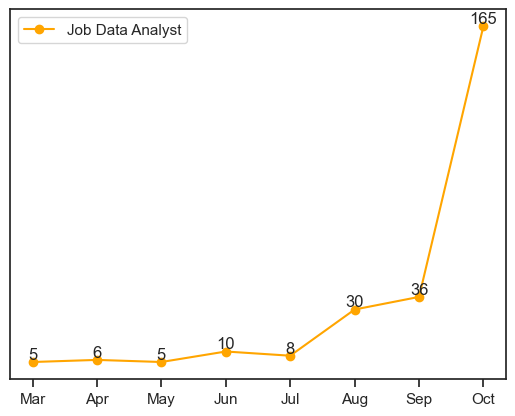

In [18]:
df['Month'] = df['date'].dt.month
df_da = df[df['title category']=='Data Analyst'] # filtering data analyst
job_monthly = df_da.groupby(['Month']).size().reset_index(name='Count') # count data analyst per month

sns.set(style="ticks")
plt.plot(job_monthly['Month'].astype(str), job_monthly['Count'], marker='o', linestyle='-', color='orange', label='Job Data Analyst')
for i, count in enumerate(job_monthly['Count']):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.yticks([]) # remove y label

plt.xticks(range(0, 8), ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])
plt.legend()
plt.show()

### 4. Export data to output

In [19]:
output_file_path_excel = "C:\\Users\\Alvin\\Documents\\Output\\DataCleansing.xlsx"
output_file_path_csv = "C:\\Users\\Alvin\\Documents\\Output\\DataCleansing.csv"
df.to_excel(output_file_path_excel, index = False)
df.to_csv(output_file_path_csv, sep = '$', index = False)